In [220]:
%load_ext autoreload
%autoreload 1

import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [801]:
from dataloaders import lvs_dataset
from analytics.full_segment_iou import total_cost_jitnet

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_padded = np.pad(y, (box_pts//2, box_pts-1-box_pts//2), mode='edge')
    y_smooth = np.convolve(y_padded, box, mode='valid')
    return y_smooth

def plot_iou(stats_dict, sequence, show_cost=False, 
             title='', new_plot=True, smooth_window=64, 
             plot_miou=False, plot_iou_cls=-1, max_frames=-1, miou_threshold=0.0,
             plot_entropy=False):
    class_names = lvs_dataset.sequence_to_class_groups_stable[sequence]
    num_classes = len(class_names) + 1
    
    if max_frames <= 0:
        max_frames = len(stats_dict)
    else:
        max_frames = min(max_frames, len(stats_dict))
    num_updates = 0
    num_samples = 0
    ents = np.zeros([max_frames,], np.float32)
    tps = np.zeros([max_frames, num_classes], np.float32)
    fps = np.zeros([max_frames, num_classes], np.float32)
    fns = np.zeros([max_frames, num_classes], np.float32)
    ious = np.zeros([max_frames, num_classes], np.float32)
    frames = np.zeros(max_frames, np.int32)
    for i, frame in enumerate(sorted(stats_dict.keys())):
        if i >= max_frames:
            break
        frame_stats = stats_dict[frame]
        miou = 0.
        for cls in range(num_classes):
            ents[i] = frame_stats['average_entropy']
            ious[i, cls] = frame_stats['iou'][cls]
            tps[i, cls] = frame_stats['tp'][cls]
            fps[i, cls] = frame_stats['fp'][cls]
            fns[i, cls] = frame_stats['fn'][cls]
            frames[i] = frame
        
        num_updates += frame_stats['num_updates']
        num_samples += frame_stats['ran_teacher']
    
    online_cost = total_cost_jitnet(max_frames, num_samples, num_updates, 300, 7, 30)
    teacher_cost = total_cost_jitnet(max_frames, max_frames, num_updates, 300, 0, 0)
    speed_up = float(teacher_cost) / online_cost
        
    eps = 1e-6
    cls_miou = (tps.sum(axis=0) + eps) / (tps.sum(axis=0) + fps.sum(axis=0) + fns.sum(axis=0) + eps)
    miou = cls_miou[1:].mean()
    if miou < miou_threshold:
        return
#     miou = (tps + eps) / (tps + fps + fns + eps)
#     miou = miou[:, 1:].mean(axis=1).mean(axis=0)
#     print(miou)
    
    if new_plot:
        plt.figure()
        
    if plot_entropy:
        plt.plot(frames, ents, label='entropy')
        return

    if plot_miou:
        x = frames
        y = ((tps + eps) / (tps + fps + fns + eps))[:, 1:].mean(axis=1)
        y = smooth(y, smooth_window)
        label = f"{title}"
        if show_cost:
            label = f'cost={speed_up:.2f} {label}'
        plt.plot(x, y, label=label)
    else:
        if plot_iou_cls > 0:
            x = frames
            y = smooth(ious[:, plot_iou_cls], smooth_window)
            plt.plot(x, y, label=f'{cls_miou[plot_iou_cls]:.3f} {title}')
        else:
            for cls in range(1, num_classes):
                x = frames
                y = smooth(ious[:, cls], smooth_window)
                plt.plot(x, y, label=class_names[cls - 1] if new_plot else title)
    if new_plot:
        plt.legend()
        plt.title(f'{title} mIoU={miou:.3f}')
#     plt.legend()

    
def extract_frame(video_path, frame_id):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cap.release()
    return frame

def image_object_stats(label, num_classes):
    # label: [H, W]
    h, w = label.shape
    x = np.linspace(0, 1, w)
    y = np.linspace(0, 1, h)
    xx, yy = np.meshgrid(x, y)
    xy = np.concatenate([xx[..., None], yy[..., None]], axis=2)
#     print(xy.shape)

    label_onehot = (np.arange(num_classes) == label[...,None]).astype(int)
#     print(label_onehot.shape)
    
    stats = np.zeros((num_classes))
    for c in range(num_classes):
        stats[c] = (label_onehot[:, :, c:c+1] * xy).sum()
    return stats
    
# print(image_object_stats(np.random.randint(0, 8, size=(720, 1280)), 8))

In [564]:
stats_dict = np.load(glob.glob('./results/soccer1_on_seq0/online_distillation_dataset.sequence=soccer1,dataset.sequence_id=0,dataset.start_frame=0,online_train.max_frames=15000/stats.npy')[0], allow_pickle=True)[0]
max_frames = len(stats_dict) 
num_classes = 2
ious = np.zeros([max_frames, num_classes], np.float32)
tps = np.zeros([max_frames, num_classes], np.float32)
fps = np.zeros([max_frames, num_classes], np.float32)
fns = np.zeros([max_frames, num_classes], np.float32)
for i, frame in enumerate(sorted(stats_dict.keys())):
    frame_stats = stats_dict[frame]
    for cls in range(num_classes):
        ious[i, cls] = frame_stats['iou'][cls]
#         tps[i, cls] = frame_stats['tp'][cls]
#         fps[i, cls] = frame_stats['fp'][cls]
#         fns[i, cls] = frame_stats['fn'][cls]

# eps = 1e-6
# tps = tps[:, 1:].sum(axis=1)
# fps = fps[:, 1:].sum(axis=1)
# fns = fns[:, 1:].sum(axis=1)
# ious = (tps + eps) / (tps + fps + fns + eps)
ious = ious[:, 1:].mean(axis=1)
mean_iou = ious.mean()
max_iou = ious.max()
min_iou = ious.min()

print(mean_iou, max_iou, min_iou)

0.77032834 0.89603746 2.7882337e-11


In [565]:
samples_p = np.array([np.random.exponential((mean_iou - min_iou) / 2) + min_iou for _ in range(max_frames)])
# np.sum(samples < (min_iou + 0.5))
samples = ious < samples_p
print(np.sum(samples))
filtered_ious = samples * ious
print(np.sum((filtered_ious < mean_iou) & (filtered_ious > 0)))
print(np.sum((filtered_ious >= mean_iou) & (filtered_ious > 0)))
print(np.sum((ious < mean_iou) & (ious > 0)))
print(np.sum((ious >= mean_iou) & (ious > 0)))

samples = []
for i in range(max_frames):
    p = np.random.exponential((mean_iou - min_iou) / 2) + min_iou
    if ious[i] < p:
        samples.append(i)

selected_ious = ious[samples]
print(np.mean(selected_ious))

2070
940
1130
5571
9430
0.7441828


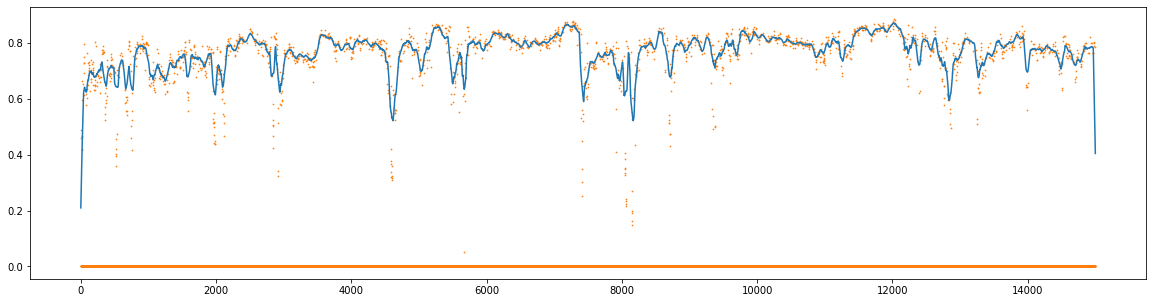

In [566]:
plt.figure(figsize=(20, 5))
plt.plot(range(max_frames), smooth(ious, 64))
plt.scatter(range(max_frames), filtered_ious, s=0.5, color='#ff7f0e')

 ## Driving

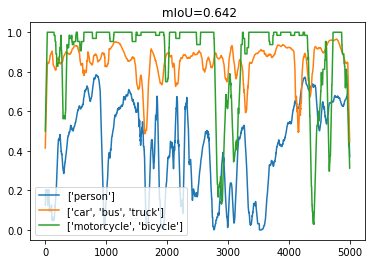

In [5]:
stats_dict = np.load('results/driving_ckpts/online_distillation_dataset.sequence=driving1,online_train.bg_weight=1,online_train.checkpoint_good_model=true,online_train.fg_weight=10,online_train.max_frames=5000,online_train.max_updates=16/stats.npy', allow_pickle=True)[0]
plot_iou(stats_dict, 'driving1')

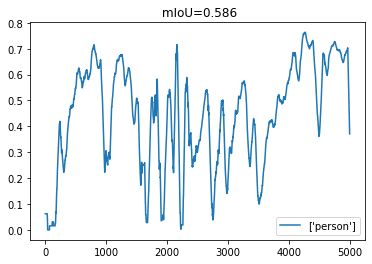

In [4]:
stats_dict = np.load('results/driving1_person_only/online_distillation_dataset.sequence=driving1,online_train.bg_weight=1,online_train.fg_weight=10,online_train.max_frames=5000,online_train.max_updates=16/stats.npy', allow_pickle=True)[0]
plot_iou(stats_dict, 'driving1')

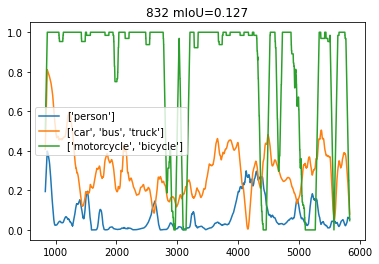

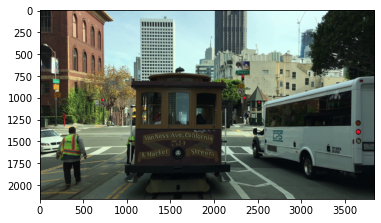

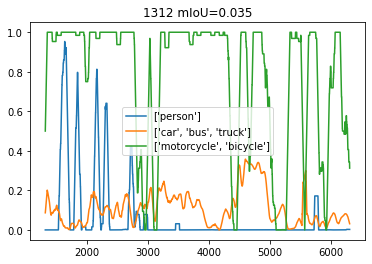

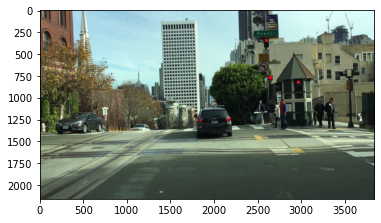

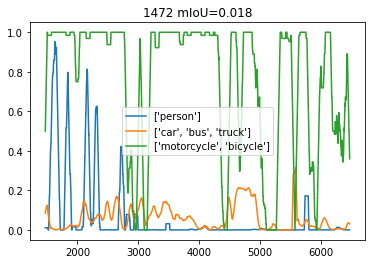

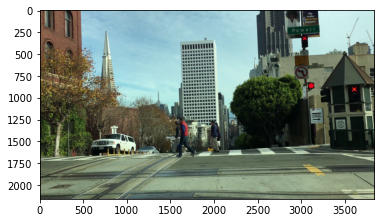

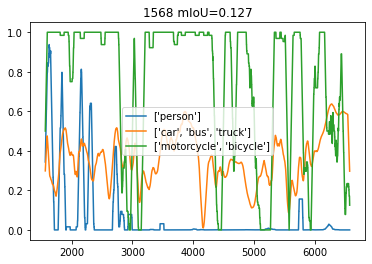

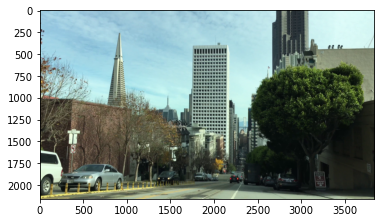

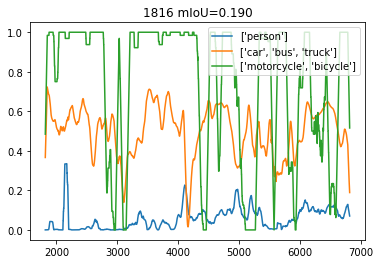

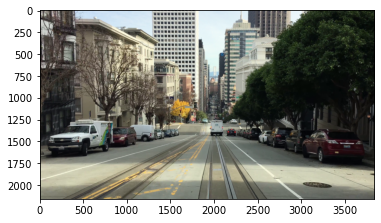

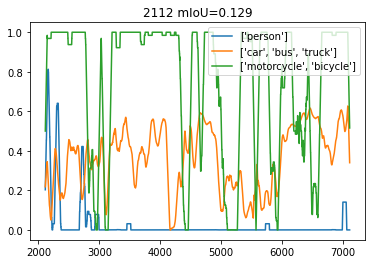

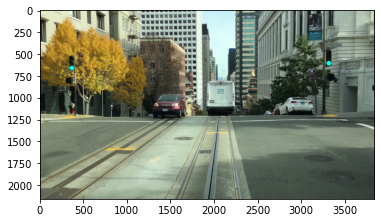

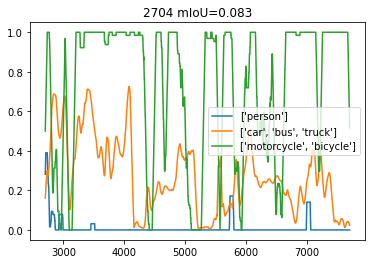

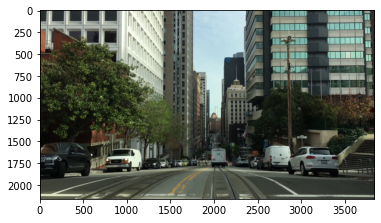

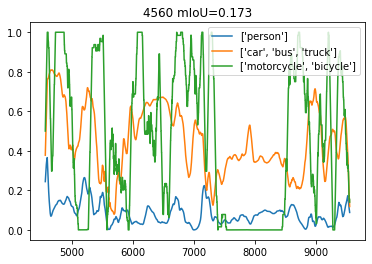

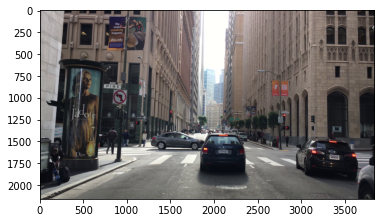

In [45]:
for i in [832, 1312, 1472, 1568, 1816, 2112, 2704, 4560]:
    stats_dict = np.load(f'results/driving_ckpts_eval_{i}/online_distillation_dataset.sequence=driving1,dataset.start_frame={i},model.ignored_vars=[],online_train.max_frames=5000,online_train.max_updates=16,online_train.online_train=false/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'driving1', title=f'{i}')
    frame = extract_frame('/home/cfan/lvsdataset/driving1/driving1000.mp4', int(i))
    plt.figure()
    plt.imshow(frame)
#     plt.title(f'{i}')

## samui_walking_street1

Text(0.5, 1.0, 'samui_walking_street online train')

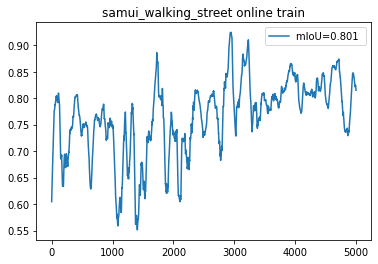

In [729]:
stats_dict = np.load('results/samui_walking_street1_ckpts/online_distillation_dataset.sequence=samui_walking_street1,online_train.bg_weight=1,online_train.checkpoint_good_model=true,online_train.fg_weight=10,online_train.max_frames=5000,online_train.max_updates=16/stats.npy', allow_pickle=True)[0]
plot_iou(stats_dict, 'samui_walking_street1', plot_miou=True, new_plot=False)
plt.legend()
plt.title('samui_walking_street online train')
# stats_dict = np.load('results/samui_walking_street1_on_seq0/online_distillation_dataset.sequence=samui_walking_street1,dataset.sequence_id=0,dataset.start_frame=0,online_train.max_frames=15000//stats.npy', allow_pickle=True)[0]
# plot_iou(stats_dict, 'samui_walking_street1', plot_miou=True, new_plot=False)

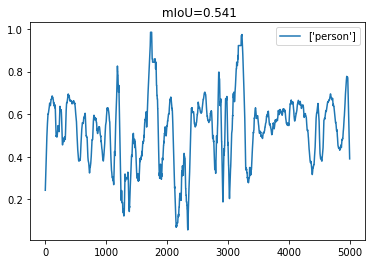

In [6]:
stats_dict = np.load('results/samui_walking_street1_person_only/online_distillation_dataset.sequence=samui_walking_street1,online_train.bg_weight=1,online_train.fg_weight=10,online_train.max_frames=5000,online_train.max_updates=16/stats.npy', allow_pickle=True)[0]
plot_iou(stats_dict, 'samui_walking_street1', show_updates=False)

Text(0, 0.5, 'mIoU')

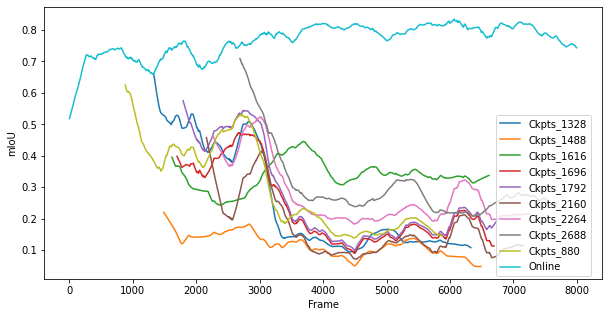

In [814]:
plt.figure(figsize=(10, 5))
for i in sorted(glob.glob('./results/samui_walking_street1_eval_*')):
    start_frame = i.split('_')[-1]
    if int(start_frame) > 3000:
        continue
    stats_dict = np.load(f'{i}/online_distillation_dataset.sequence=samui_walking_street1,dataset.start_frame={start_frame},model.ignored_vars=[],online_train.max_frames=5000,online_train.max_updates=16,online_train.online_train=false/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'samui_walking_street1', title=f'Ckpts_{start_frame}', new_plot=False, plot_miou=True, max_frames=5000, smooth_window=512)
#     frame = extract_frame('/home/cfan/lvsdataset/samui_walking_street1/samui_walking_street1001.mp4', int(start_frame))
#     plt.figure()
#     plt.imshow(frame)

stats_dict = np.load('results/samui_walking_street1_on_seq0/online_distillation_dataset.sequence=samui_walking_street1,dataset.sequence_id=0,dataset.start_frame=0,online_train.max_frames=15000/stats.npy', allow_pickle=True)[0]
plot_iou(stats_dict, 'samui_walking_street1', plot_miou=True, new_plot=False, title='Online', smooth_window=512, max_frames=8000)

# plt.title('Online vs. Checkpoints')
plt.legend(loc=(0.81, 0.01))
plt.xlabel('Frame')
plt.ylabel('mIoU')


## table_tennis1

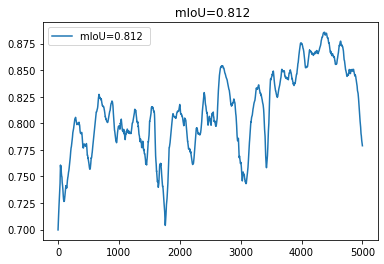

In [697]:
stats_dict = np.load('results/table_tennis1_ckpts/online_distillation_dataset.sequence=table_tennis1,online_train.bg_weight=1,online_train.checkpoint_good_model=true,online_train.fg_weight=10,online_train.max_frames=5000,online_train.max_updates=16/stats.npy', allow_pickle=True)[0]
plot_iou(stats_dict, 'table_tennis1', plot_miou=True)


(-0.5, 1279.5, 719.5, -0.5)

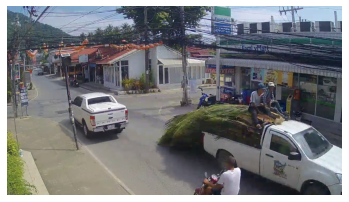

In [792]:
frame = extract_frame('/home/cfan/lvsdataset/samui_walking_street1/samui_walking_street1001.mp4', int(2010))
plt.figure()
plt.imshow(frame)
plt.axis('off')

Text(0, 0.5, 'mIoU')

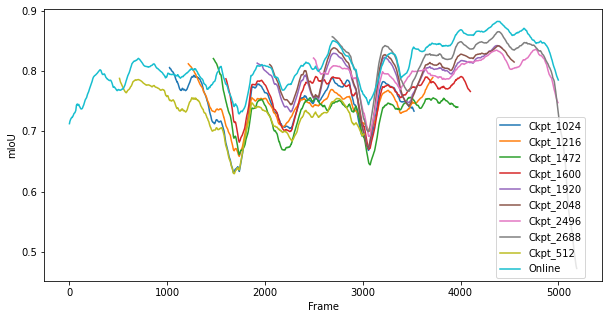

In [815]:
plt.figure(figsize=(10,5))
for i in sorted(glob.glob('./results/table_tennis1_ckpts_eval2_*')):
    start_frame = i.split('_')[-1]
    if int(start_frame) > 3000:
        continue
    stats_dict = np.load(f'{i}/online_distillation_dataset.start_frame={start_frame},model.ignored_vars=[],online_train.max_frames=2500,online_train.online_train=false/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'table_tennis1', title=f'Ckpt_{start_frame}', new_plot=False, plot_miou=True, smooth_window=128)
#     frame = extract_frame('/home/cfan/lvsdataset/table_tennis1/table_tennis1000.mp4', int(start_frame))
#     plt.figure()
#     plt.imshow(frame)
plt.legend(loc=(1.04, 0))

# stats_dict = np.load('results/table_tennis1_on_seq0/online_distillation_dataset.sequence=table_tennis1,online_train.max_frames=15000/stats.npy', allow_pickle=True)[0]
stats_dict = np.load('./results/table_tennis1_ckpts/online_distillation_dataset.sequence=table_tennis1,online_train.bg_weight=1,online_train.checkpoint_good_model=true,online_train.fg_weight=10,online_train.max_frames=5000,online_train.max_updates=16/stats.npy', allow_pickle=True)[0]
plot_iou(stats_dict, 'table_tennis1', plot_miou=True, new_plot=False, title='Online', smooth_window=128, max_frames=6500)

# plt.title('Online vs. Checkpoints')
plt.legend(loc=(0.81, 0.01))
plt.xlabel('Frame')
plt.ylabel('mIoU')

In [70]:
detections = np.load('/home/cfan/lvsdataset/table_tennis1/detectron_large_mask_rcnn_1_table_tennis1000.npy', allow_pickle=True)[()]

[[0.         0.45121951 0.28085107 ... 0.19261214 0.23280423 0.22646311]
 [0.45121951 0.         0.31042129 ... 0.20821918 0.2264151  0.20769231]
 [0.28085107 0.31042129 0.         ... 0.19466667 0.232      0.21012658]
 ...
 [0.19261214 0.20821918 0.19466667 ... 0.         0.6        0.51851852]
 [0.23280423 0.2264151  0.232      ... 0.6        0.         0.63636364]
 [0.22646311 0.20769231 0.21012658 ... 0.51851852 0.63636364 0.        ]]


<Figure size 720x720 with 0 Axes>

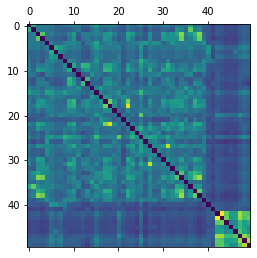

In [761]:
from dataloaders.maskrcnn_stream import batch_segmentation_masks

# frame_ids = [1000, 1002, 1004, 1008, 1016, 1032, 1064, 1128]
frame_ids = np.arange(1000, 6000, 100)

sequence = 'table_tennis1'
sequence_id = 0

stats_labels = {}
label_accumulated = None
dataset = lvs_dataset.LVSDataset('/data3/cfan/lvsdataset', 
                                 sequence,
                                 str(sequence_id).zfill(3),
                                 start_frame=0,
                                 max_frames=0,
                                 stride=1)
class_groups = lvs_dataset.sequence_to_class_groups_stable[sequence]
class_groups = [ [lvs_dataset.detectron_classes.index(c) for c in g] \
                 for g in class_groups]
for frame_id in frame_ids:
    frame, labels_vals, _ = dataset[frame_id]
    labels_vals = labels_vals.int().numpy()
    labels_vals = labels_vals[::16, ::16]
    if frame_id % 1 == 0:
        if label_accumulated is None:
            label_accumulated = labels_vals
        obj_stats = image_object_stats(label_accumulated, len(class_groups) + 1)
        stats_labels[frame_id] = label_accumulated
        label_accumulated = None
    else:
        if label_accumulated is None:
            label_accumulated = labels_vals
        label_accumulated = label_accumulated | labels_vals
#     print(labels_vals.shape)
    
#     plt.figure()
#     plt.imshow(labels_vals[0])
#     plt.title(f'{frame_id} {obj_stats}')

def cal_iou(a, b):
    a = a.astype(np.bool)
    b = b.astype(np.bool)
    intersection = (a & b).sum()
    union = (a | b).sum()
    eps = 1e-6
    return (intersection + eps) / (union + eps)

total = len(stats_labels.keys())
iou_mat = np.zeros((total, total))
all_keys = list(stats_labels.keys())
for i in range(total):
    for j in range(i + 1, total):
        if j == i:
            continue
        iou_mat[i, j] = cal_iou(stats_labels[all_keys[i]], 
                                stats_labels[all_keys[j]])
iou_mat = iou_mat + iou_mat.T
print(iou_mat)
plt.figure(figsize=(10, 10))
plt.matshow(iou_mat)



# for k in sorted(stats_labels.keys()):
#     plt.figure()
#     plt.imshow(stats_labels[k])
#     plt.title(f'{k}')

/home/cfan/miniconda3/envs/jitnet/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


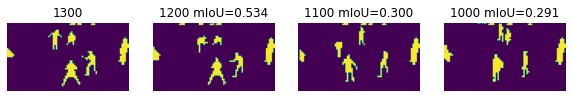

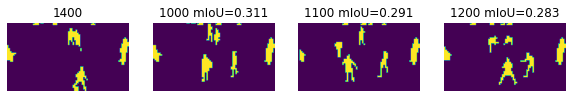

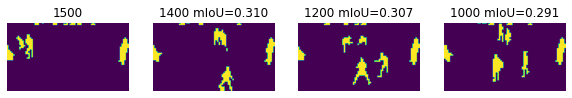

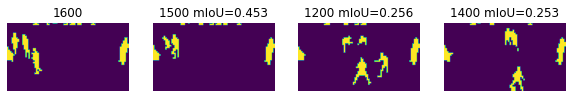

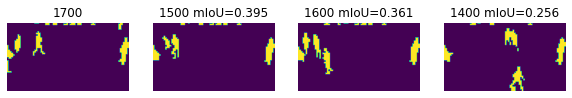

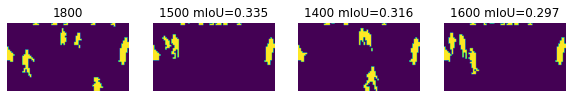

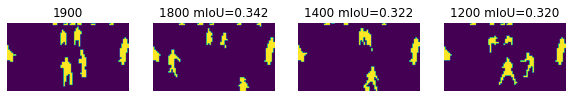

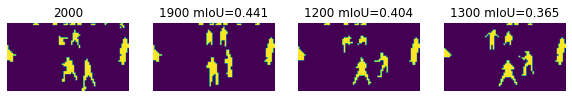

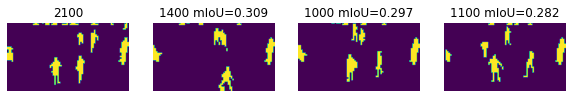

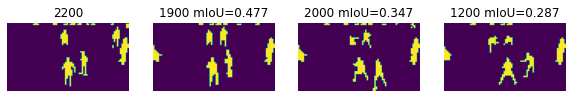

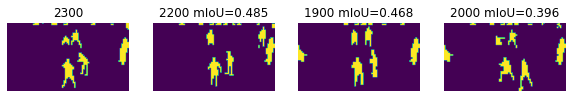

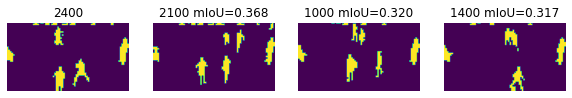

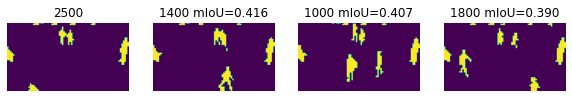

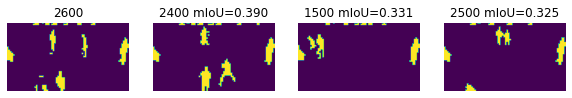

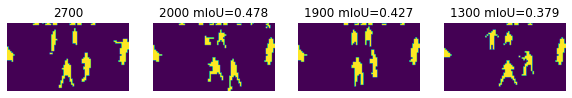

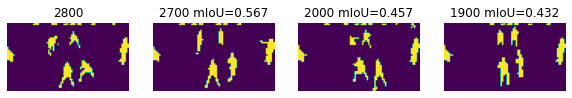

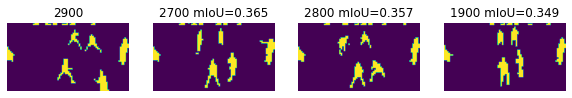

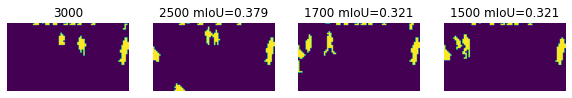

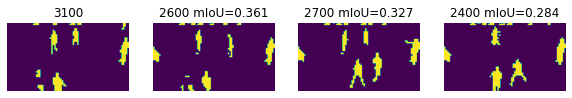

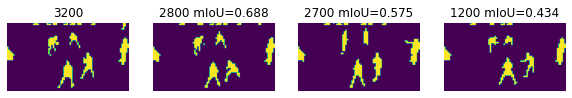

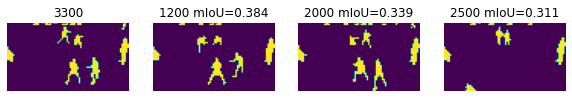

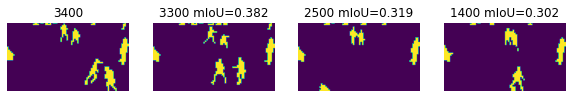

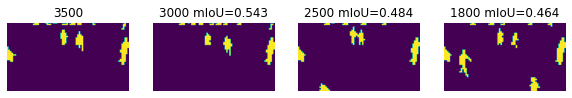

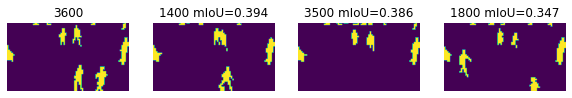

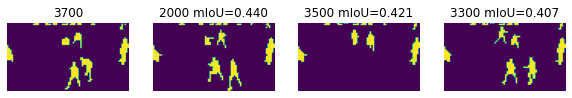

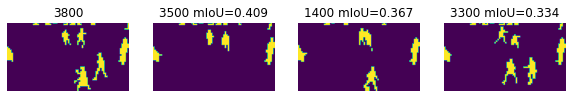

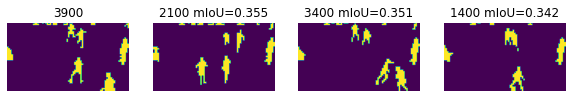

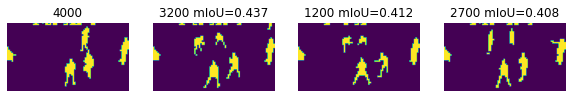

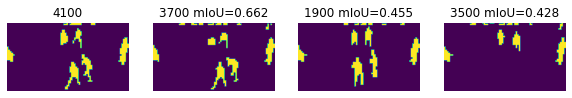

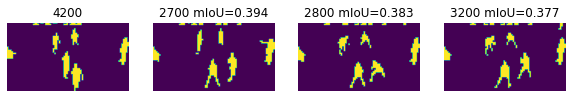

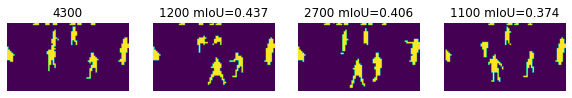

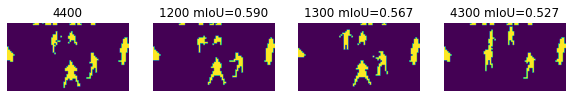

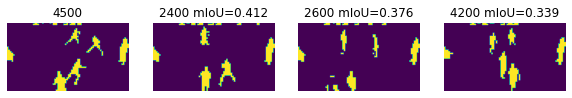

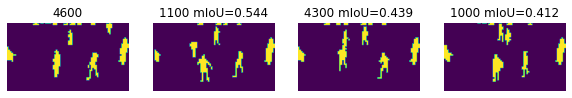

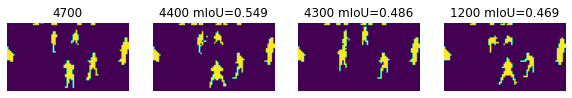

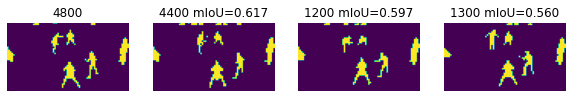

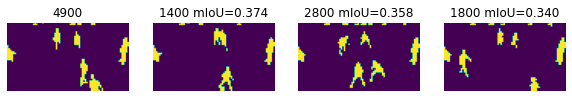

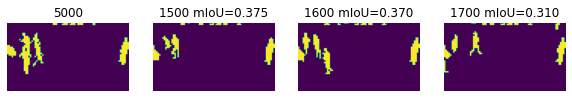

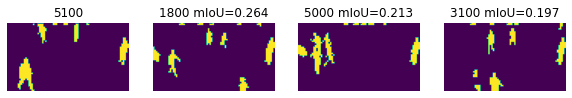

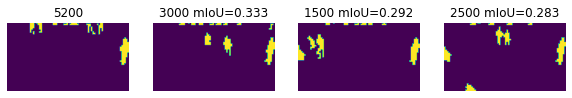

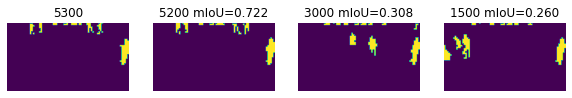

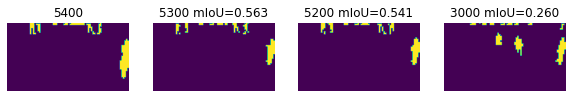

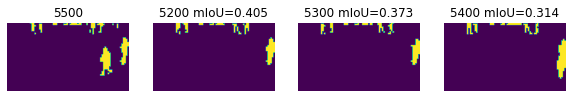

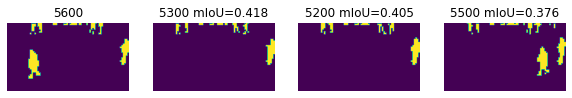

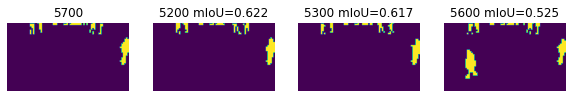

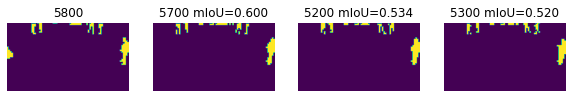

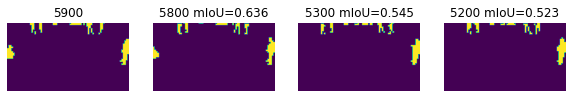

In [767]:
for i in range(3, total):
    j = np.argmax(iou_mat[i])
    js = iou_mat[i, :i].argsort()[::-1][:3]
#     js = iou_mat[i].argsort()[-3:]

#     js = np.argpartition(iou_mat[i], -3)[-3:]
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    axs[0].imshow(stats_labels[all_keys[i]])
    axs[0].title.set_text(f'{all_keys[i]}')
    axs[0].axis('off')
    for k, j in enumerate(js):
        axs[k + 1].imshow(stats_labels[all_keys[j]])
        axs[k + 1].title.set_text(f'{all_keys[j]} mIoU={iou_mat[i, j]:.3f}')
        axs[k + 1].axis('off')

Text(0.5, 1.0, 'Similar Checkpoints Reuse')

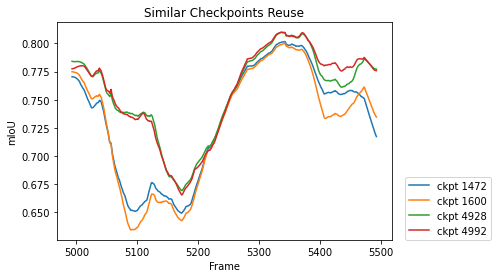

In [778]:
plt.figure()
for i in sorted(glob.glob('./results/table_tennis1_ckpts_retrain_*_f4993')):
    start_frame = 4993
    stats_dict = np.load(f'{i}/online_distillation_dataset.sequence=table_tennis1,dataset.start_frame={start_frame},model.ignored_vars=[],online_train.max_frames=500/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'table_tennis1', title=f"ckpt {i.split('_')[-2]}", new_plot=False, smooth_window=64)
#     frame = extract_frame('/home/cfan/lvsdataset/table_tennis1/table_tennis1000.mp4', int(start_frame))
#     plt.figure()
#     plt.imshow(frame)
plt.legend(loc=(1.04, 0))
plt.xlabel('Frame')
plt.ylabel('mIoU')
plt.title('Similar Checkpoints Reuse')

Text(0.5, 1.0, 'Similar Checkpoints Reuse')

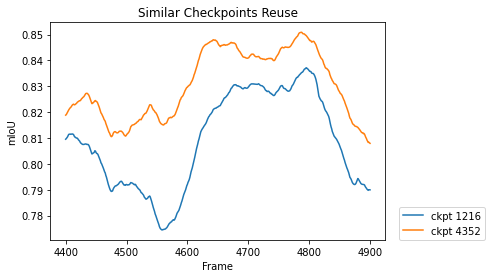

In [779]:
plt.figure()
for i in sorted(glob.glob('./results/table_tennis1_ckpts_retrain_*_f4400')):
    start_frame = 4400
    stats_dict = np.load(f'{i}/online_distillation_dataset.sequence=table_tennis1,dataset.start_frame={start_frame},model.ignored_vars=[],online_train.max_frames=500/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'table_tennis1', title=f"ckpt {i.split('_')[-2]}", new_plot=False, smooth_window=64)
#     frame = extract_frame('/home/cfan/lvsdataset/table_tennis1/table_tennis1000.mp4', int(start_frame))
#     plt.figure()
#     plt.imshow(frame)
plt.legend(loc=(1.04, 0))
plt.xlabel('Frame')
plt.ylabel('mIoU')
plt.title('Similar Checkpoints Reuse')

# Specializing on yesterday's data

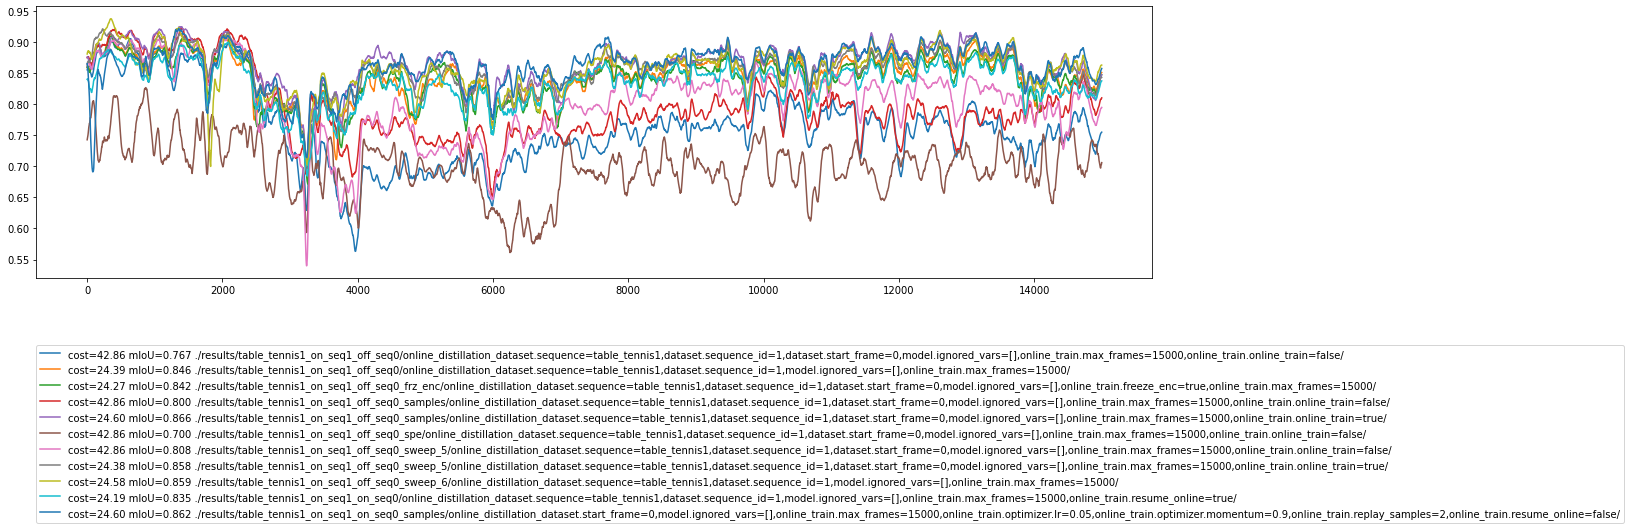

In [721]:
plt.figure(figsize=(20,5))
for i in sorted(glob.glob('./results/table_tennis1_on_seq1*/*/')):
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'table_tennis1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=15000, show_cost=True)
plt.legend(loc=(0, -0.9))

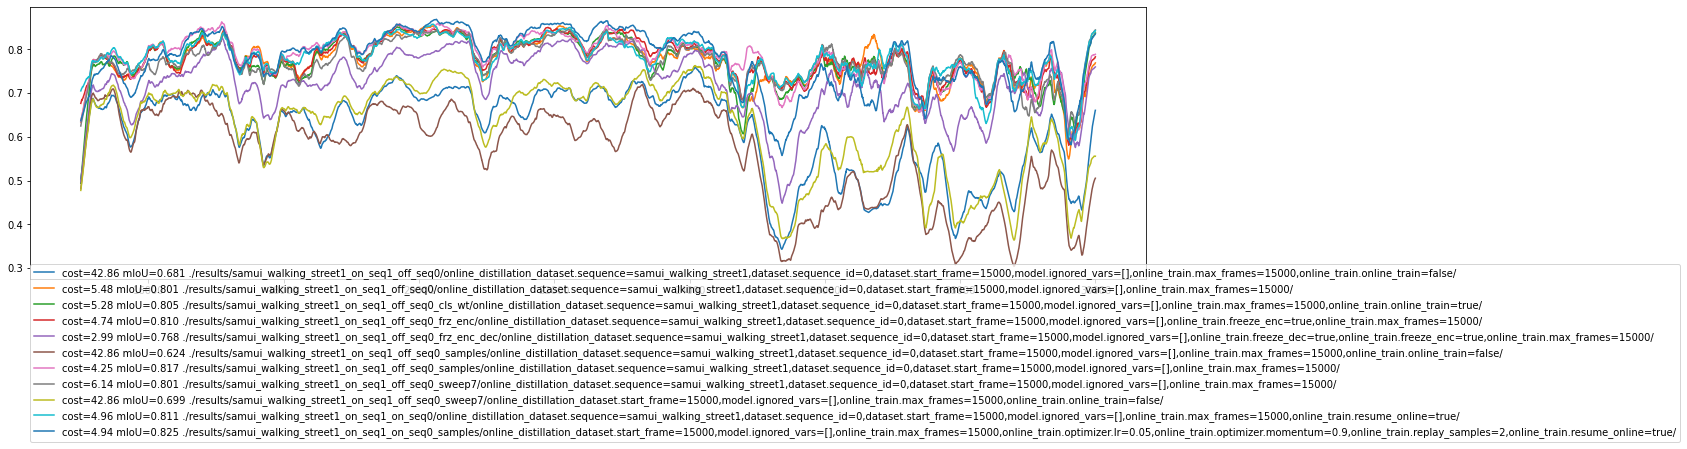

In [795]:
plt.figure(figsize=(20,5))
for i in sorted(glob.glob('./results/samui_walking_street1_on_seq1*/online*max_frames=15000*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'samui_walking_street1', title=f'{i}', new_plot=False, smooth_window=256, plot_miou=True, max_frames=15000, show_cost=True)
plt.legend(loc=(0, -0.6))

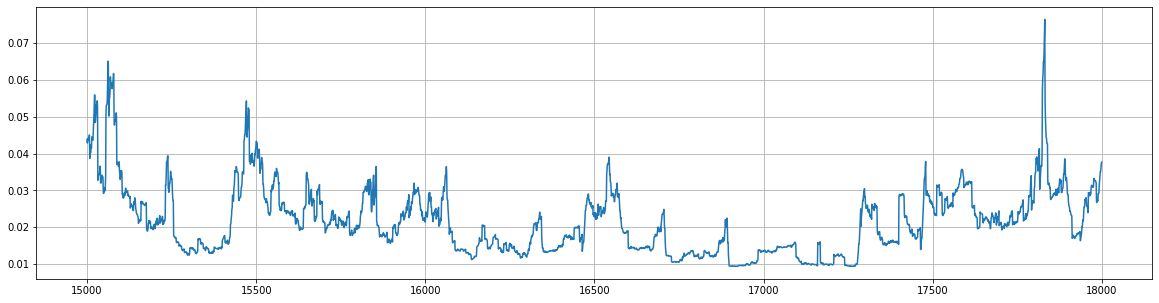

In [590]:
plt.figure(figsize=(20,5))
for i in sorted(glob.glob('./results/samui_walking_street1_on_seq1_on_seq0/online_distillation_dataset.sequence=samui_walking_street1,dataset.sequence_id=0,dataset.start_frame=15000,model.ignored_vars=[],online_train.max_frames=15000,online_train.resume_online=true/')
               ):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'samui_walking_street1', title=f'{i}', new_plot=False, smooth_window=1, plot_entropy=True, max_frames=3000)
# plt.legend(loc=(0, -0.1))
plt.grid(True)

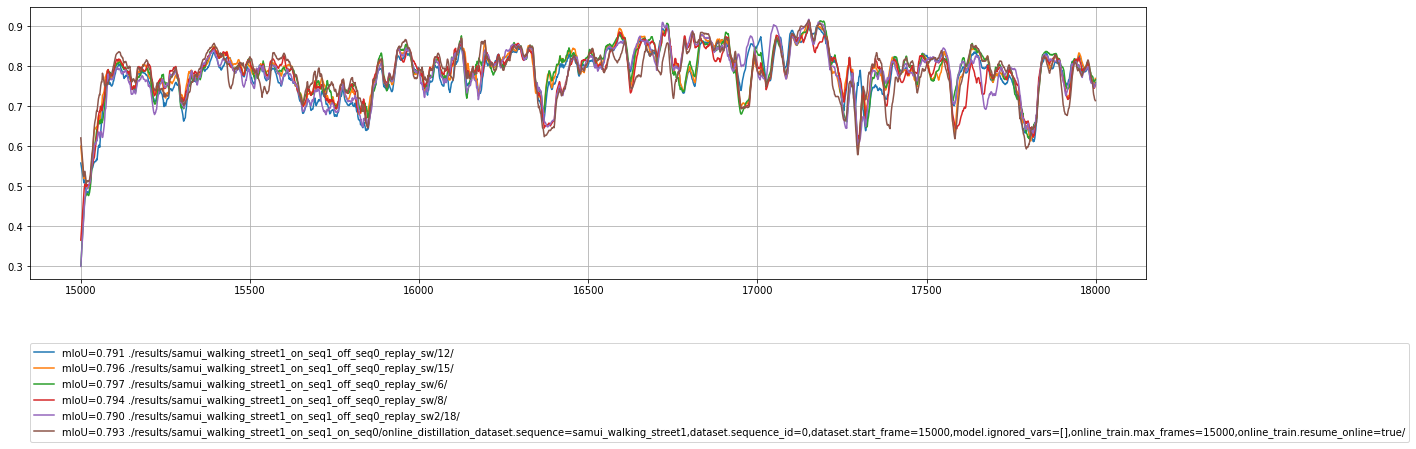

In [723]:
plt.figure(figsize=(20,5))
for i in sorted(glob.glob('./results/samui_walking_street1_on_seq1_on_seq0/online_distillation_dataset.sequence=samui_walking_street1,dataset.sequence_id=0,dataset.start_frame=15000,model.ignored_vars=[],online_train.max_frames=15000,online_train.resume_online=true/')
               + glob.glob('./results/samui_walking_street1_on_seq1_off_seq0_replay_sw/*/')
               + glob.glob('./results/samui_walking_street1_on_seq1_off_seq0_replay_sw2/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'samui_walking_street1', title=f'{i}', new_plot=False, smooth_window=16, plot_miou=True, miou_threshold=0.79, max_frames=3000)
plt.legend(loc=(0, -0.6))
plt.grid(True)

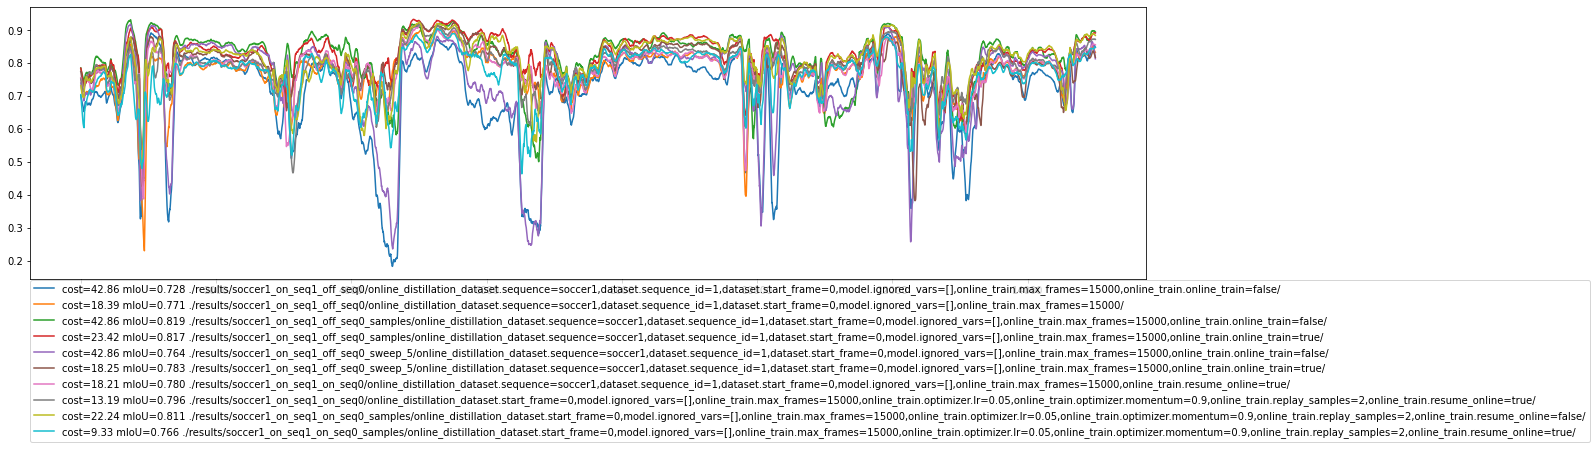

In [724]:
plt.figure(figsize=(20,5))
for i in sorted(glob.glob('./results/soccer1_on_seq1*/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'soccer1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=15000, show_cost=True)
plt.legend(loc=(0, -0.6))

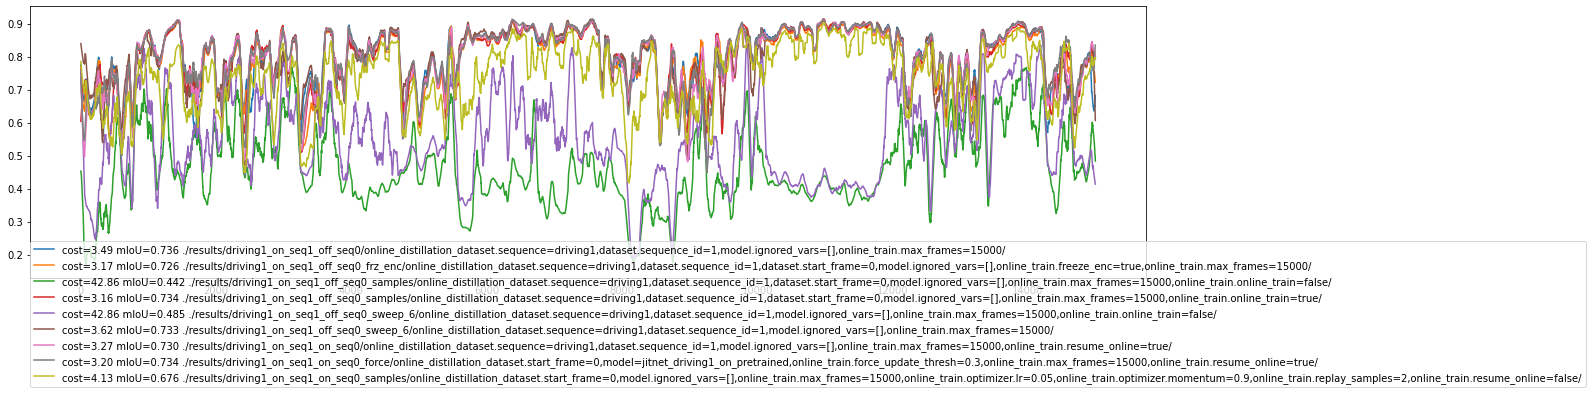

In [725]:
plt.figure(figsize=(20, 5))
for i in sorted(glob.glob('./results/driving1_on_seq1*/online*15000*/')):
#     print(i)
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'driving1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=15000, show_cost=True)
plt.legend(loc=(0, -0.4))

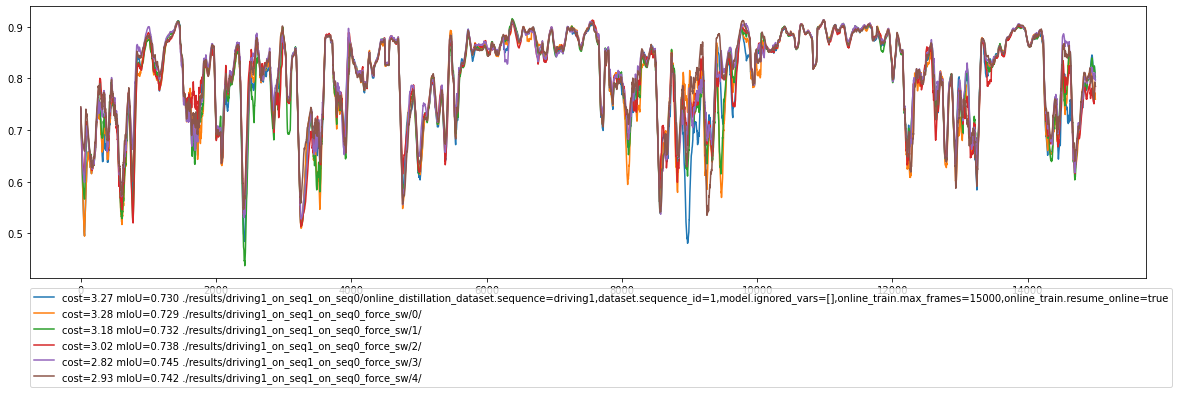

In [726]:
plt.figure(figsize=(20, 5))
for i in sorted(glob.glob('./results/driving1_on_seq1_on_seq0_force_sw/*/')
               + glob.glob('./results/driving1_on_seq1_on_seq0/*')):
#     print(i)
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'driving1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=15000, show_cost=True)
plt.legend(loc=(0, -0.4))

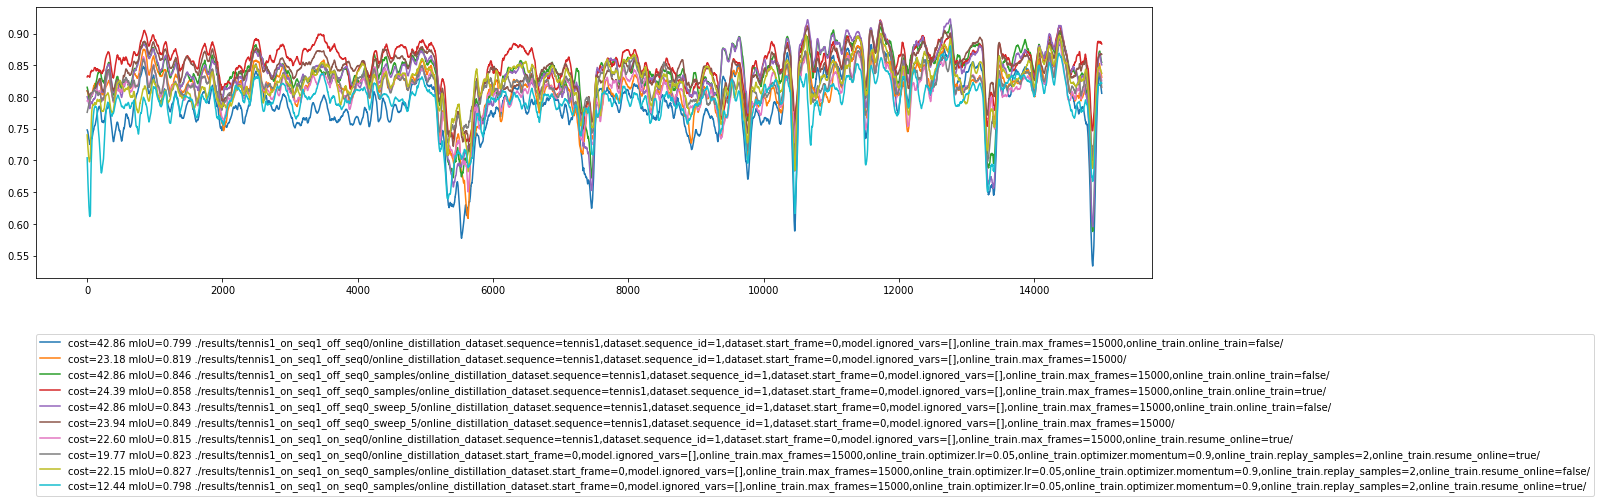

In [727]:
plt.figure(figsize=(20, 5))
for i in sorted(glob.glob('./results/tennis1_on_seq1*/online*/')):
#     print(i)
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'tennis1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=15000, show_cost=True)
plt.legend(loc=(0, -0.8))

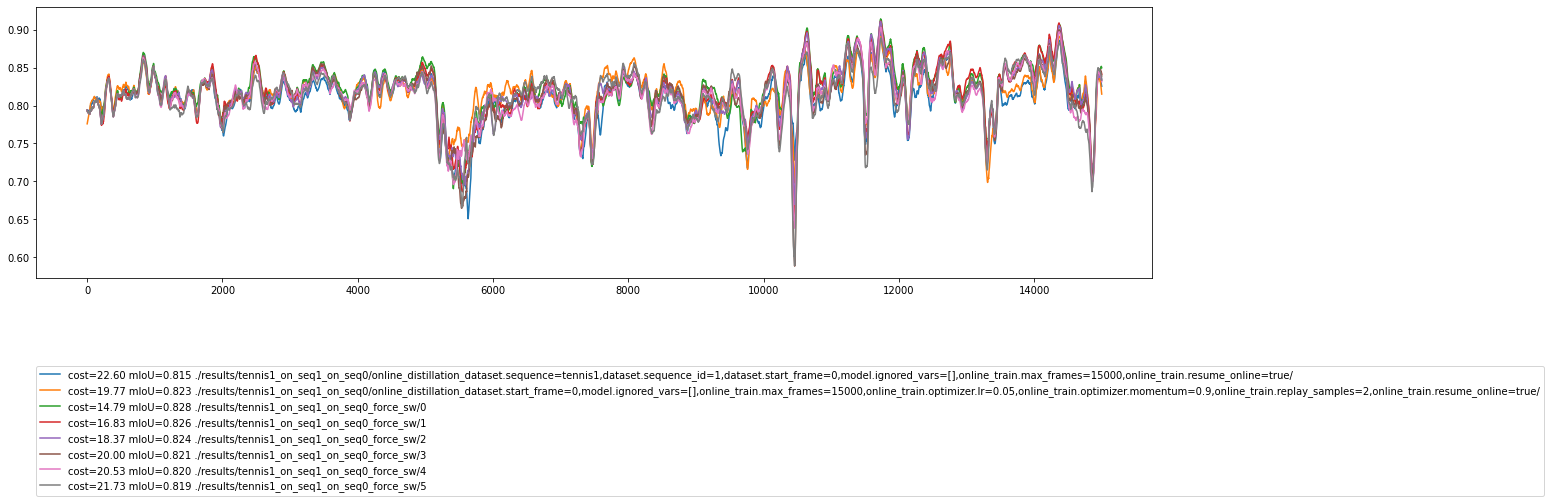

In [728]:
plt.figure(figsize=(20, 5))
for i in sorted(glob.glob('./results/tennis1_on_seq1_on_seq0/online*/') + glob.glob('./results/tennis1_on_seq1_on_seq0_force_sw/*')):
#     print(i)
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'tennis1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=15000, show_cost=True)
plt.legend(loc=(0, -0.8))

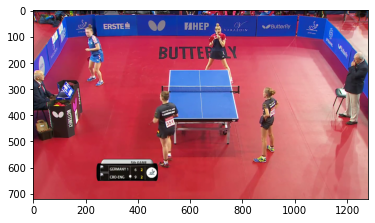

In [692]:
frame = extract_frame('/data3/cfan/lvsdataset/table_tennis1/table_tennis1001.mp4', int(367))
plt.figure()
plt.imshow(frame)

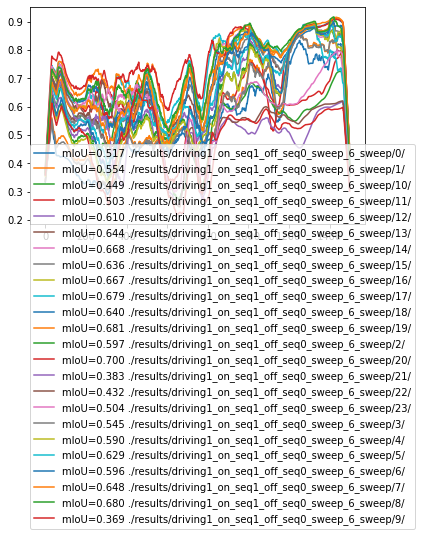

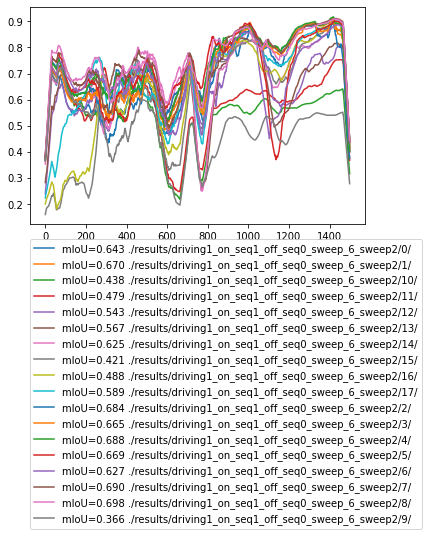

In [105]:
plt.figure()
for i in sorted(glob.glob('./results/driving1_on_seq1*_sweep/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'driving1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=1500)
plt.legend(loc=(0, -1.4))

plt.figure()
for i in sorted(glob.glob('./results/driving1_on_seq1*_sweep2/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'driving1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=1500)
plt.legend(loc=(0, -1.4))

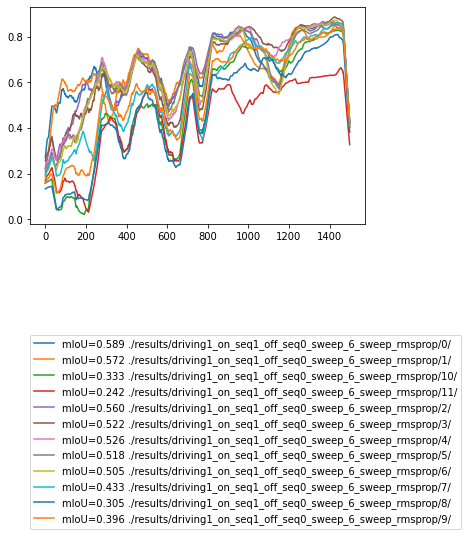

In [112]:
plt.figure()
for i in sorted(glob.glob('./results/driving1_on_seq1*_sweep_rmsprop/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'driving1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=1500)
plt.legend(loc=(0, -1.4))

# Multiple models

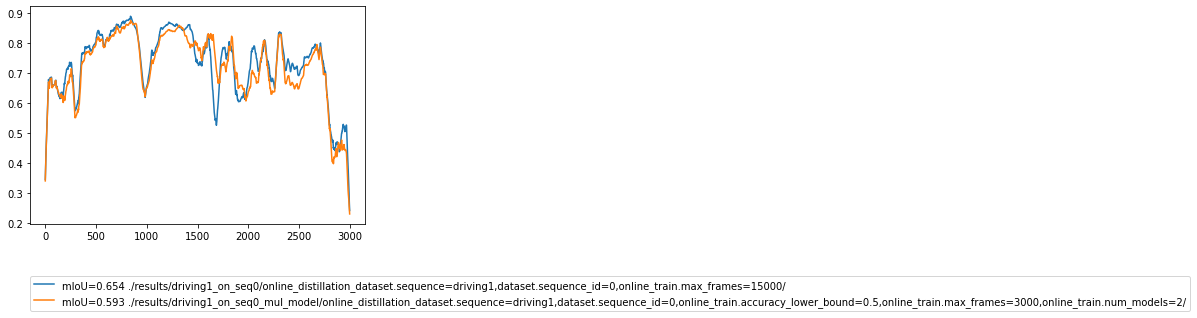

In [118]:
plt.figure()
for i in sorted(glob.glob('./results/driving1_on_seq0_mul_model/*/') + glob.glob('./results/driving1_on_seq0/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'driving1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=3000)
plt.legend(loc=(0, -0.4))

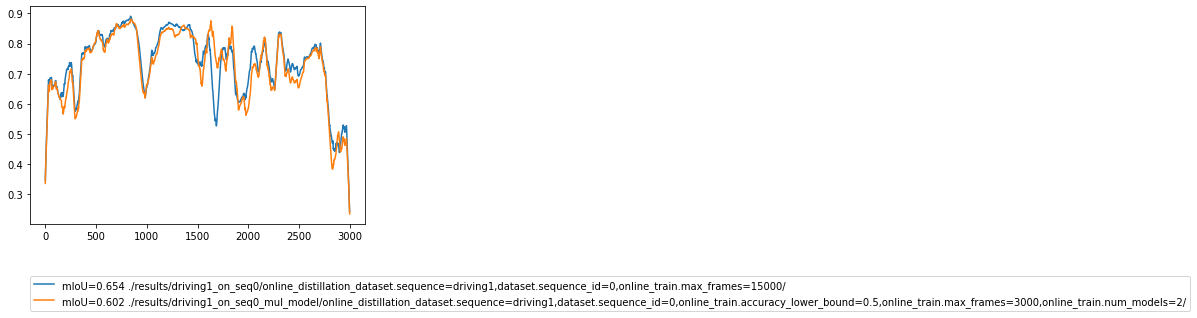

In [119]:
plt.figure()
for i in sorted(glob.glob('./results/driving1_on_seq0_mul_model/*/') + glob.glob('./results/driving1_on_seq0/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'driving1', title=f'{i}', new_plot=False, smooth_window=64, plot_miou=True, max_frames=3000)
plt.legend(loc=(0, -0.4))

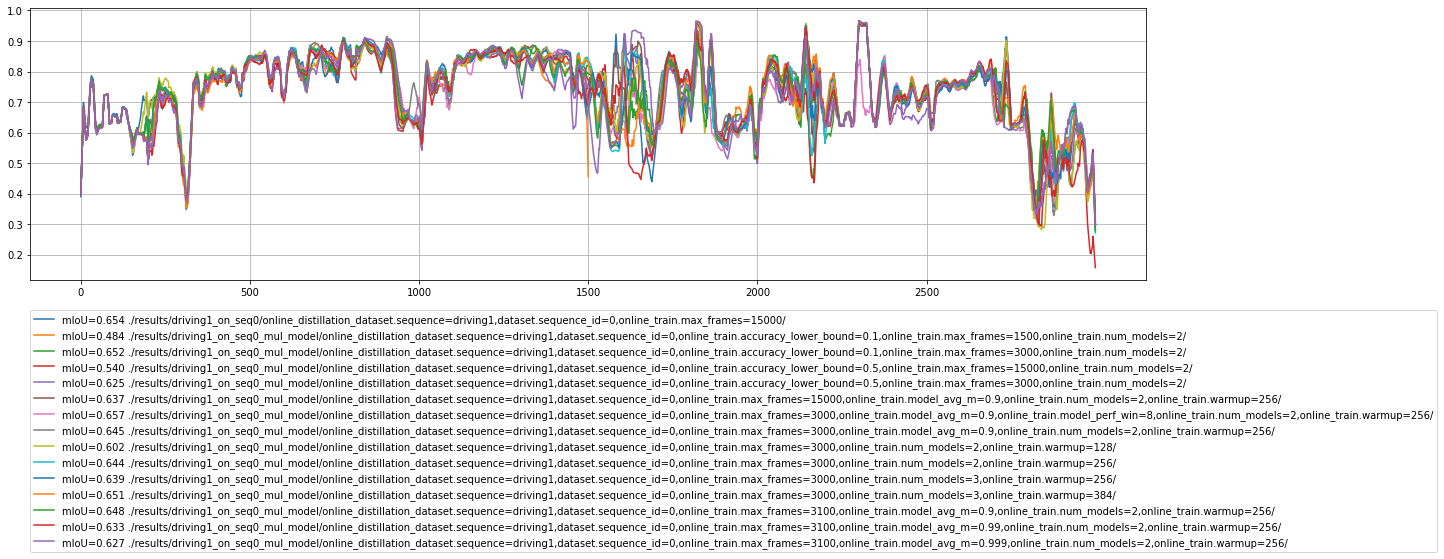

In [202]:
plt.figure(figsize=(20, 5))
for i in sorted(glob.glob('./results/driving1_on_seq0_mul_model/*/') + glob.glob('./results/driving1_on_seq0/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    plot_iou(stats_dict, 'driving1', title=f'{i}', new_plot=False, smooth_window=16, plot_miou=True, max_frames=3000)
plt.xticks(np.arange(0, 3000, 500))
plt.grid(True)
plt.legend(loc=(0, -1))


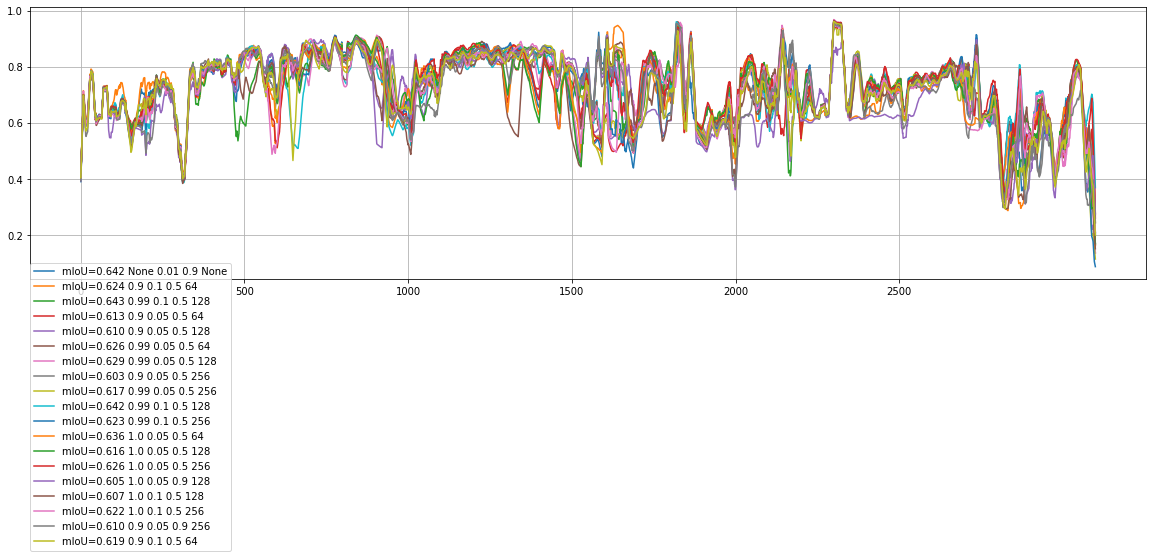

In [247]:
plt.figure(figsize=(20, 5))
for i in sorted(glob.glob('./results/driving1_on_seq0_mul_model_sweep/*/') + glob.glob('./results/driving1_on_seq0/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    conf = OmegaConf.load(f'{i}/.hydra/config.yaml')
    title = f'{conf.online_train.model_avg_m} {conf.online_train.optimizer.lr} {conf.online_train.optimizer.momentum} {conf.online_train.model_perf_win}'
    plot_iou(stats_dict, 'driving1', title=title, new_plot=False, smooth_window=16, plot_miou=True, max_frames=3100, miou_threshold=0.6)
plt.xticks(np.arange(0, 3000, 500))
plt.grid(True)
plt.legend(loc=(0, -1))


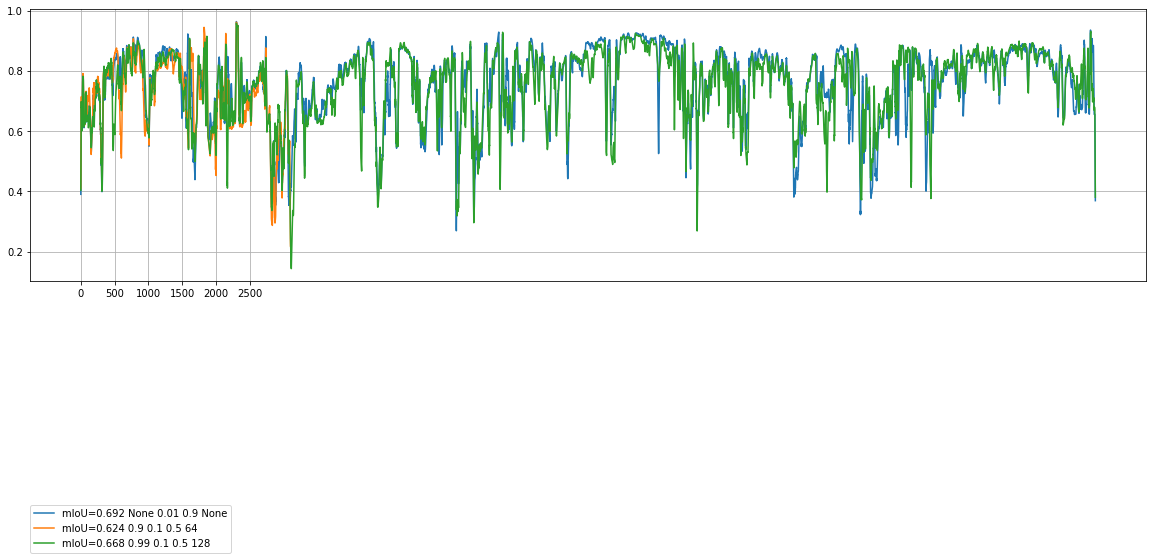

In [242]:
plt.figure(figsize=(20, 5))
for i in sorted(glob.glob('./results/driving1_on_seq0/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    conf = OmegaConf.load(f'{i}/.hydra/config.yaml')
    title = f'{conf.online_train.model_avg_m} {conf.online_train.optimizer.lr} {conf.online_train.optimizer.momentum} {conf.online_train.model_perf_win}'
    plot_iou(stats_dict, 'driving1', title=title, new_plot=False, smooth_window=16, plot_miou=True, max_frames=15000, miou_threshold=0.6)
plt.xticks(np.arange(0, 3000, 500))
plt.grid(True)
plt.legend(loc=(0, -1))


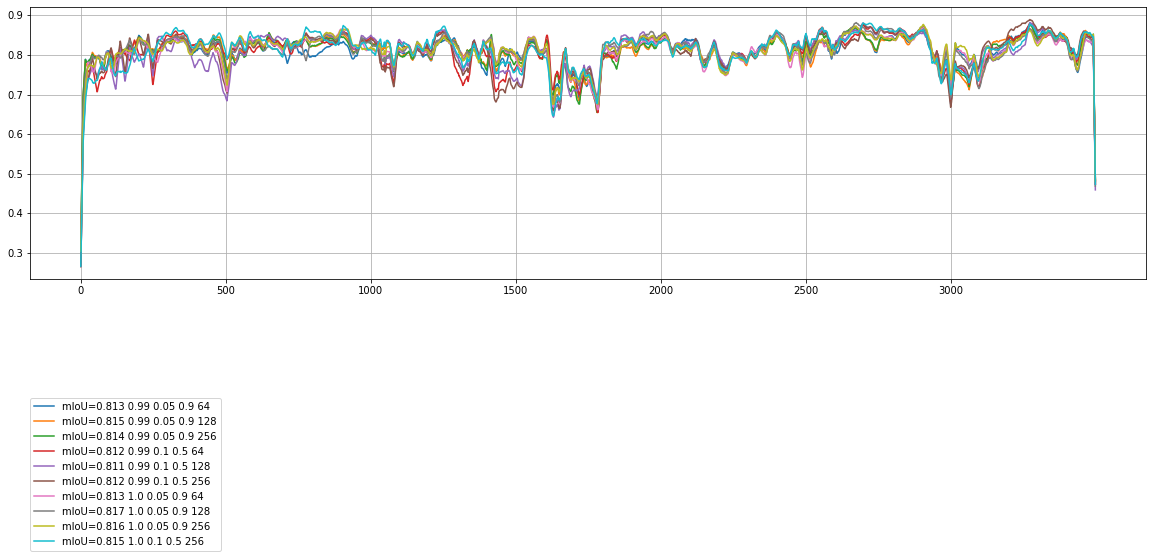

In [237]:
plt.figure(figsize=(20, 5))
for i in sorted(glob.glob('./results/table_tennis1_on_seq0_mul_model_sweep/*/') + glob.glob('./results/table_tennis1_on_seq0/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
#     print(i)
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    conf = OmegaConf.load(f'{i}/.hydra/config.yaml')
    title = f'{conf.online_train.model_avg_m} {conf.online_train.optimizer.lr} {conf.online_train.optimizer.momentum} {conf.online_train.model_perf_win}'
    plot_iou(stats_dict, 'table_tennis1', title=title, 
             new_plot=False, smooth_window=16, plot_miou=True, max_frames=3500, miou_threshold=0.810)
plt.xticks(np.arange(0, 3500, 500))
plt.grid(True)
plt.legend(loc=(0, -1))


./results/table_tennis1_on_seq0/online_distillation_dataset.sequence=table_tennis1,dataset.sequence_id=0,online_train.max_frames=3500,online_train.optimizer.lr=0.05/
./results/table_tennis1_on_seq0/online_distillation_dataset.sequence=table_tennis1,online_train.max_frames=15000,online_train.model_avg_m=0.99,online_train.model_perf_win=64,online_train.num_models=2,online_train.optimizer.lr=0.1,online_train.optimizer.momentum=0.5/
./results/table_tennis1_on_seq0/online_distillation_dataset.sequence=table_tennis1,online_train.max_frames=15000,online_train.model_avg_m=1.0,online_train.model_perf_win=128,online_train.num_models=2,online_train.optimizer.lr=0.05,online_train.optimizer.momentum=0.9/
./results/table_tennis1_on_seq0/online_distillation_dataset.sequence=table_tennis1,online_train.max_frames=15000,online_train.model_avg_m=1.0,online_train.model_perf_win=256,online_train.num_models=2,online_train.optimizer.lr=0.1,online_train.optimizer.momentum=0.5/
./results/table_tennis1_on_seq0/

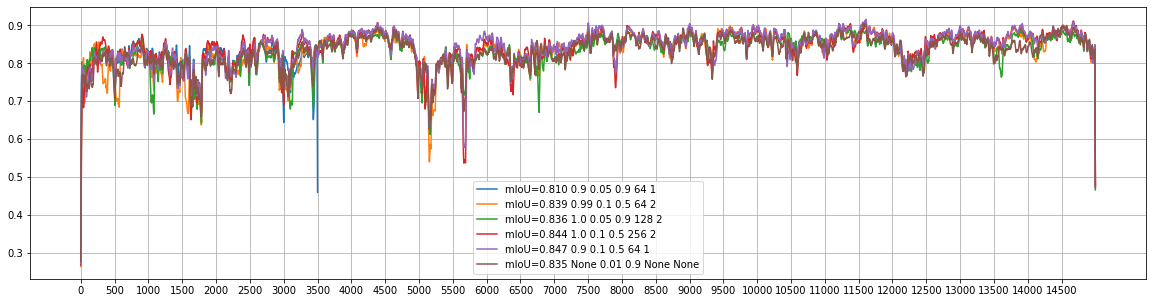

In [301]:
plt.figure(figsize=(20, 5))
for i in sorted(glob.glob('./results/table_tennis1_on_seq0/*/')):
    if not os.path.exists(f'{i}/stats.npy'):
        continue
    print(i)
    stats_dict = np.load(f'{i}/stats.npy', allow_pickle=True)[0]
    conf = OmegaConf.load(f'{i}/.hydra/config.yaml')
    title = f'{conf.online_train.model_avg_m} {conf.online_train.optimizer.lr} {conf.online_train.optimizer.momentum} {conf.online_train.model_perf_win} {conf.online_train.num_models}'
    plot_iou(stats_dict, 'table_tennis1', title=title, 
             new_plot=False, smooth_window=16, plot_miou=True, max_frames=15000, miou_threshold=0.10)
plt.xticks(np.arange(0, 15000, 500))
plt.grid(True)
plt.legend()


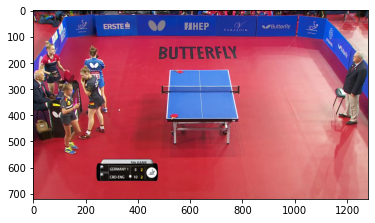

In [294]:
frame = extract_frame('/home/cfan/lvsdataset/table_tennis1/table_tennis1001.mp4', int(1800))
plt.figure()
plt.imshow(frame)